# Optimizing the RNN

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading TensorBoard
%load_ext tensorboard

# Clear any logs from previous runs
# %rm -rf ./logs/

In [3]:
from tensorboard.plugins.hparams import api as hp

In [4]:
import random
random.seed(123)

# Configuring hyperparameters

In [5]:
# Optimizers (SGD, Adam, Adamax, RMSprop)
optimizers = [
    'adam', 
    'sgd', 
    'adamax', 
    'rmsprop'
]


# Loss functions (MeanSquaredError, Huber, MeanSquaredLogarithmicError)
loss_functions = [
    'huber', 
    'MeanSquaredError', 
    'MeanSquaredLogarithmicError'
]

In [6]:
# Hyperparameters
LSTM_UNITS = hp.HParam('LSTM_units', hp.Discrete([16, 32, 64, 128]))
OPTIMIZER = hp.HParam('Optimizer', hp.Discrete(optimizers))
LOSS_FUNCTION = hp.HParam('Loss_function', hp.Discrete(loss_functions))

# TODO: APPLY
HP_DROPOUT = hp.HParam('Dropout', hp.Discrete([0.0, 0.1, 0.2]))
HP_BATCH_SIZE = 'TODO'
HP_WINDOW_SIZE = 'TODO'
# END TODO

# Metrics
METRIC_RMSE = 'RootMeanSquaredError'


with tf.summary.create_file_writer('logs/RNN').as_default():
    hp.hparams_config(
    # Parameters
    hparams = [
        LSTM_UNITS,
        OPTIMIZER,
        LOSS_FUNCTION
        
#         HP_DROPOUT,
#         HP_BATCH_SIZE,
#         HP_WINDOW_SIZE
    ],
    # Metrics
    metrics = [
        hp.Metric(
            METRIC_RMSE, display_name='RMSE'
        ),
    ]
    )

# Loading the dataset

In [7]:
df = pd.read_csv('extracted_data/csv/hour_merged.csv',
                 parse_dates={'data': ['date', 'time']},
                 infer_datetime_format=True,
                 dayfirst=False,
                 index_col='data'
                )


df.head()

,price,demand,emissions
data,,,
2017-01-01 00:00:00,58.82,24682,14467.2840
2017-01-01 01:00:00,58.23,24046,14173.8295
2017-01-01 02:00:00,51.95,22665,13198.0690
2017-01-01 03:00:00,47.27,21200,12510.7595
2017-01-01 04:00:00,45.49,20056,12203.7315


In [8]:
df.describe()

,price,demand,emissions
count,43800.000000,43800.000000,43800.000000
mean,68.212629,28189.487146,11296.974971
std,63.725022,4595.460802,3952.947375
min,0.010000,16165.000000,3890.149500
25%,40.500000,24380.750000,8181.419000
50%,51.200000,28218.000000,10769.564250
75%,64.100000,31687.000000,13794.362000
max,536.810000,41552.000000,30476.416000


In [9]:
# Select 2021
# df = df[int((len(df)*0.6)):]
df = df[int((len(df)*0.8)):]

In [10]:
df.describe()

,price,demand,emissions
count,8760.000000,8760.000000,8760.000000
mean,149.843062,27748.348744,9344.160081
std,105.417526,4247.456217,3377.646274
min,0.010000,17443.000000,3890.149500
25%,61.360000,24236.500000,6815.296250
50%,121.995000,27959.500000,8704.811500
75%,240.502500,30857.250000,11209.781125
max,536.810000,41552.000000,24229.262000


# Differencing

In [11]:
df.head()

,price,demand,emissions
data,,,
2021-01-01 00:00:00,50.87,25134,6356.6480
2021-01-01 01:00:00,48.19,24179,6269.1480
2021-01-01 02:00:00,44.68,22472,5702.4820
2021-01-01 03:00:00,38.50,20319,5284.9275
2021-01-01 04:00:00,36.80,19040,5218.2340


In [12]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [13]:
diff_price = difference(df['price'])
diff_emissions = difference(df['emissions'])
diff_demand = difference(df['demand'])

In [14]:
s1 = pd.Series([0.0])
diff_price = s1.append(diff_price, ignore_index=True)
diff_emissions = s1.append(diff_emissions, ignore_index=True)
diff_demand = s1.append(diff_demand, ignore_index=True)

In [15]:
df['price'] = diff_price.values
df['demand'] = diff_demand.values
df['emissions'] = diff_emissions.values

In [16]:
df.head()

,price,demand,emissions
data,,,
2021-01-01 00:00:00,0.00,0.0,0.0000
2021-01-01 01:00:00,-2.68,-955.0,-87.5000
2021-01-01 02:00:00,-3.51,-1707.0,-566.6660
2021-01-01 03:00:00,-6.18,-2153.0,-417.5545
2021-01-01 04:00:00,-1.70,-1279.0,-66.6935


# Split into training and test

In [17]:
n = len(df)

train_df = df[0:int(n*0.8)]
test_df = df[int(n*0.8):]

# Normalization/Standarization

In [18]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [19]:
train_df.head()

,price,demand,emissions
data,,,
2021-01-01 00:00:00,-0.001166,0.000057,-0.000507
2021-01-01 01:00:00,-0.121941,-0.737243,-0.163255
2021-01-01 02:00:00,-0.159345,-1.317819,-1.054494
2021-01-01 03:00:00,-0.279669,-1.662149,-0.777150
2021-01-01 04:00:00,-0.077777,-0.987385,-0.124555


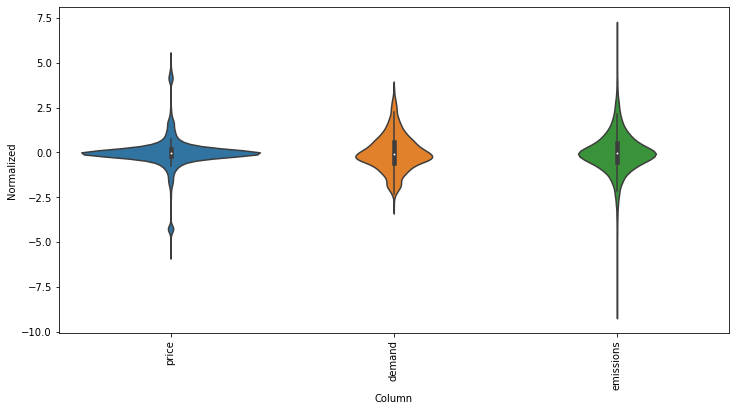

In [20]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Creation of windows

In [21]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [24]:
OUT_STEPS = 24
# If no label_columns, TensorFlow will use all the columns
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)
multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

In [25]:
example_window = tf.stack([np.array(test_df[:multi_window.total_window_size]),
                           np.array(test_df[100:100+multi_window.total_window_size]),
                           np.array(test_df[200:200+multi_window.total_window_size])
                          ])

example_inputs, example_labels = multi_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 3)
Inputs shape: (3, 24, 3)
Labels shape: (3, 24, 3)


In [26]:
multi_window.example = example_inputs, example_labels

In [27]:
def plot(self, model=None, plot_col='price', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [28]:
# De momento, usaremos únicamente la target variable (Household dataset)
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

WindowGenerator.train = train
WindowGenerator.test = test

In [30]:
multi_window.train.element_spec

(TensorSpec(shape=(None, 24, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 3), dtype=tf.float32, name=None))

In [31]:
# Iteramos sobre un conjunto de dataset para producir lotes concretos:
for example_inputs, example_labels in multi_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 3)
Labels shape (batch, time, features): (32, 24, 3)


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

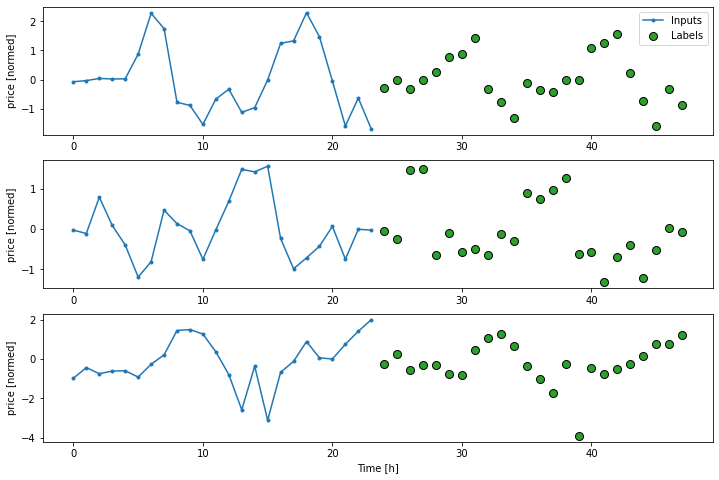

In [32]:
multi_window.plot()
multi_window

In [33]:
print(multi_window)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None


# RNN

## Convert the model into a function

In [34]:
MAX_EPOCHS = 5
patience = 4
num_features=df.shape[1]
window = multi_window

In [35]:
# multi_val_performance = {}
# multi_performance = {}

In [36]:
# def train_test_model(hparams):
#     multi_lstm_model = tf.keras.Sequential([
#         # Shape [batch, time, features] => [batch, lstm_units]
#         # Es peligroso añadir demasiadas unidades lstm, ya que pueden causar overfitting
#         tf.keras.layers.LSTM(hparams[LSTM_UNITS], return_sequences=False),
#         # Shape [batch, out_steps*features]
#         tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
#         tf.keras.layers.Dropout(.1),
#         # Shape [batch, out_steps, features]
#         tf.keras.layers.Reshape([OUT_STEPS, num_features])
#     ])
    
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
#     multi_lstm_model.compile(loss=hparams[LOSS_FUNCTION],
#                  optimizer=hparams[OPTIMIZER],
#                  metrics=[tf.metrics.RootMeanSquaredError()])
    
#     history = multi_lstm_model.fit(window.train, epochs=MAX_EPOCHS, validation_data = window.val, 
#                         callbacks=[early_stopping]
#                        )
    
#     print(multi_lstm_model.evaluate(multi_window.test, verbose=0))
#     loss, rmse = multi_lstm_model.evaluate(multi_window.test, verbose=0)
    
#     return rmse

For each execution, generate a log containing the hyperparameter configuration and the metrics (rmse)

In [37]:
# def run(run_dir, hparams):
#     with tf.summary.create_file_writer(run_dir).as_default():
#         hp.hparams(hparams)  # record the values used in this trial
#         rmse = train_test_model(hparams)
        
#         tf.summary.scalar(METRIC_RMSE, rmse, step=1)

In [38]:
# session_num = 0

# for lstm_unit in LSTM_UNITS.domain.values:
#     for optimizer in OPTIMIZER.domain.values:
#         for loss_function in LOSS_FUNCTION.domain.values:
#             hparams = {
#                 LSTM_UNITS: lstm_unit,
#                 OPTIMIZER: optimizer,
#                 LOSS_FUNCTION: loss_function
#             }
#             run_name = "run-%d" % session_num
#             print('--- Starting trial: %s' % run_name)
#             print({h.name: hparams[h] for h in hparams})
#             run('logs/RNN/' + run_name, hparams)
#             session_num += 1

In [39]:
# %tensorboard --logdir logs/RNN --port 6009

In [40]:
# %tensorboard --logdir logs/RNN

---------------------------------------------
# Draft
---------------------------------------------

In [41]:
multi_lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units]
        # Es peligroso añadir demasiadas unidades lstm, ya que pueden causar overfitting
        tf.keras.layers.LSTM(128, return_sequences=False),
        # Shape [batch, out_steps*features]
        tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Dropout(.1),
        # Shape [batch, out_steps, features]
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

multi_lstm_model.compile(loss='huber',
                 optimizer='adamax',
                 metrics=[tf.metrics.RootMeanSquaredError()])
    
history = multi_lstm_model.fit(window.train, epochs=MAX_EPOCHS, validation_data = window.test, 
                        callbacks=[early_stopping]
                       )
    
print(multi_lstm_model.evaluate(multi_window.test, verbose=0))
loss, rmse = multi_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/5
218/218 [==============================] - 6s 22ms/step - loss: 0.2670 - root_mean_squared_error: 0.8701 - val_loss: 0.3194 - val_root_mean_squared_error: 0.9442
Epoch 2/5
218/218 [==============================] - 5s 24ms/step - loss: 0.2207 - root_mean_squared_error: 0.7911 - val_loss: 0.2932 - val_root_mean_squared_error: 0.9051
Epoch 3/5
218/218 [==============================] - 6s 26ms/step - loss: 0.2086 - root_mean_squared_error: 0.7684 - val_loss: 0.2854 - val_root_mean_squared_error: 0.8912
Epoch 4/5
218/218 [==============================] - 5s 24ms/step - loss: 0.2051 - root_mean_squared_error: 0.7615 - val_loss: 0.2793 - val_root_mean_squared_error: 0.8793
Epoch 5/5
218/218 [==============================] - 5s 25ms/step - loss: 0.2014 - root_mean_squared_error: 0.7541 - val_loss: 0.2724 - val_root_mean_squared_error: 0.8626
[0.27239954471588135, 0.8625797629356384]


# Workaround with trained model
TODOs:
- Apply transform/unstransform
- Print three features (Done)
- Remove val set
- Transform dataframe to window (Done)

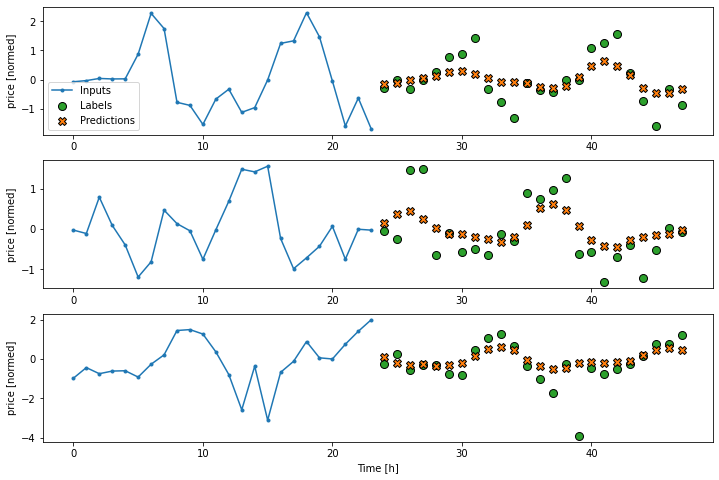

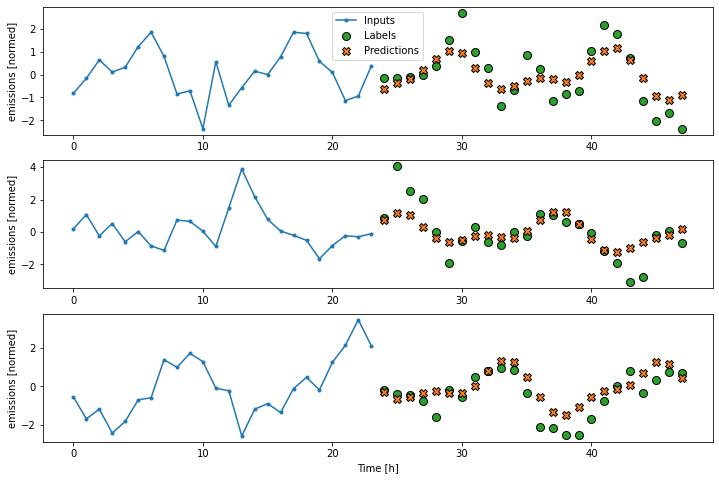

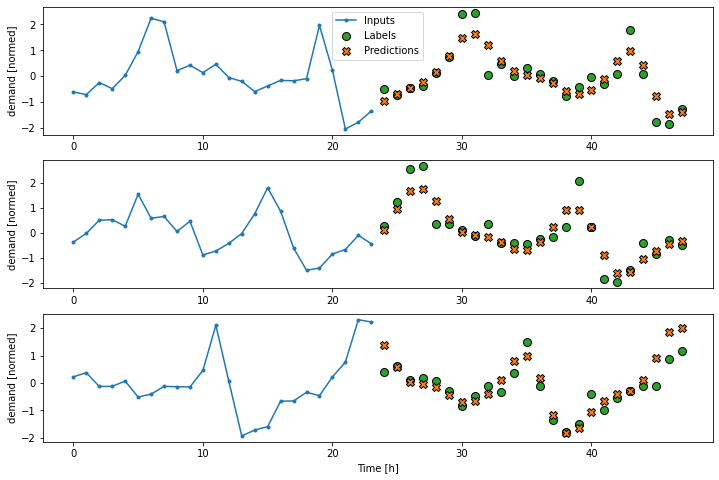

In [42]:
# Print three features
# Printing price
multi_window.plot(multi_lstm_model)

# Printing emissions
multi_window.plot(multi_lstm_model, plot_col='emissions')

# Printing demand
multi_window.plot(multi_lstm_model, plot_col='demand')

# Transform SUBdataframe to window

In [43]:
new_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)
new_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

In [44]:
subset = test_df[len(test_df)-new_window.total_window_size:]

In [45]:
example_window2 = tf.stack([
    np.array(subset)
])

example_inputs, example_labels = new_window.split_window(example_window2)

In [46]:
new_window.example = example_inputs, example_labels

In [47]:
subset.head(n=10)

,price,demand,emissions
data,,,
2021-12-30 00:00:00,-0.643346,-1.648253,-0.591763
2021-12-30 01:00:00,-0.633882,-0.936430,-0.016318
2021-12-30 02:00:00,-0.366645,-1.170359,-0.392177
2021-12-30 03:00:00,-0.141319,-0.646142,-0.138363
2021-12-30 04:00:00,-0.021445,-0.271702,-0.093479
2021-12-30 05:00:00,-0.025952,0.081122,0.617389
2021-12-30 06:00:00,0.732496,0.836951,0.525294
2021-12-30 07:00:00,0.154309,1.786562,1.270591
2021-12-30 08:00:00,1.887519,1.875347,-0.035566


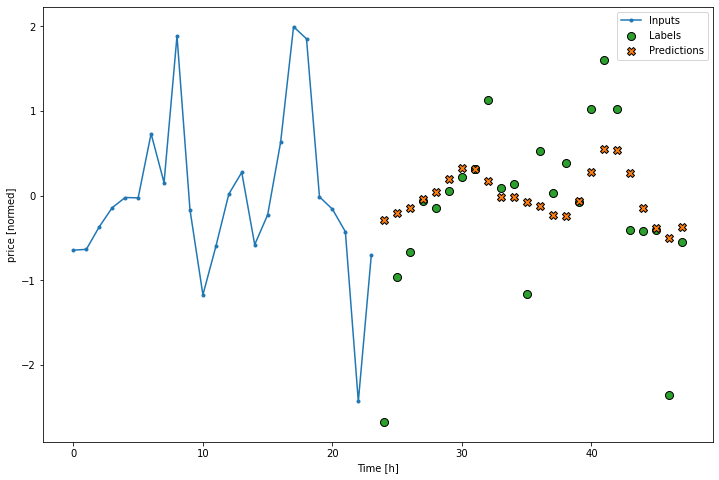

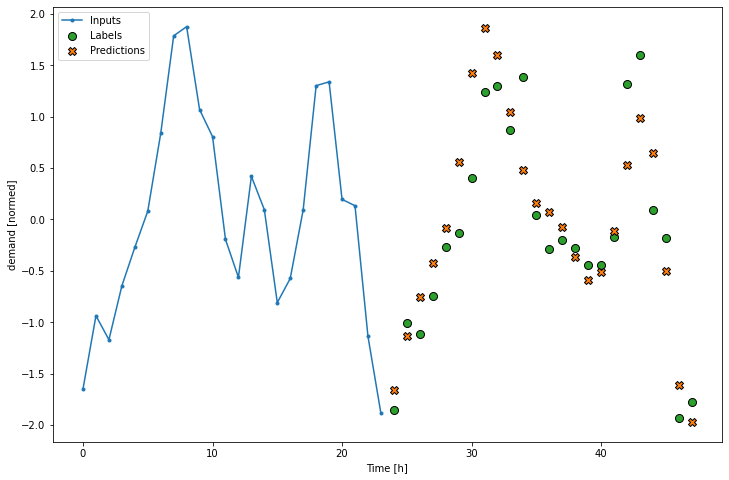

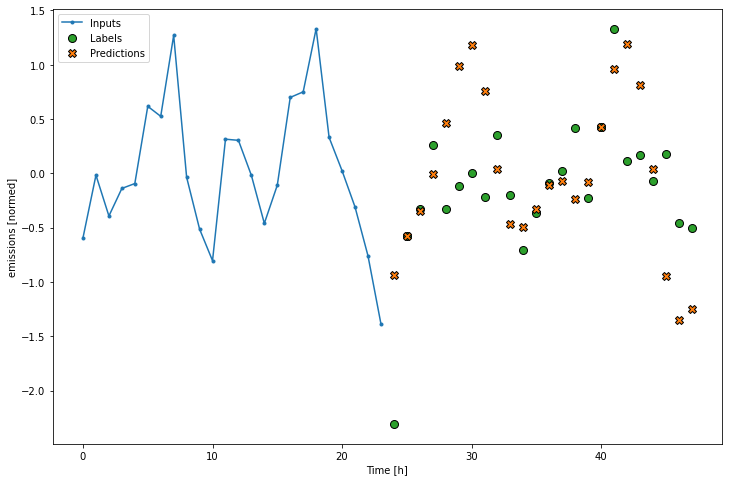

In [48]:
# Price
new_window.plot(multi_lstm_model)

# Emissions
new_window.plot(multi_lstm_model, plot_col='demand')

# Demand
new_window.plot(multi_lstm_model, plot_col='emissions')